취약 계층(X) - 독거 노인 수, 기초생활 수급자 수
취약 요인(Y) - 재개발 현황, 유흥주점 수

In [209]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import rc # 폰트 세팅을 위한 모듈 추가
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import SpectralClustering

In [210]:
# 폰트 설정
import matplotlib.pyplot as plt

plt.rc('font', family='NanumGothic')

In [211]:
import folium
import geopandas as gpd
from folium.features import GeoJson
import geopandas as gpd
from shapely.geometry import Polygon

# 전국 행정동 경계 데이터 
seoul = gpd.read_file("./data/Z_SOP_BND_ADM_DONG_PG/Z_SOP_BND_ADM_DONG_PG.shp",encoding='cp949')

hd = ['가양1동','가양2동','가양3동','공항동','등촌1동','등촌2동','등촌3동',
      '발산1동','방화1동','방화2동','방화3동','염창동','우장산동',
      '화곡1동','화곡2동','화곡3동','화곡4동','화곡6동','화곡8동','화곡본동']
for i in range(len(seoul)):
    if seoul.ADM_DR_NM[i] not in hd : #강서구 행정동이 아니면 드랍
        seoul.drop(index = i ,inplace = True)
seoul.drop(index = [1028, 1029],inplace= True) #동명이동이 있어서 확인후 드랍
seoul = seoul[['ADM_DR_NM','geometry']] 
seoul = seoul.to_crs(epsg=4326)

# 행정동명과 폴리곤 경계를 사전형태로 만드는 작업
dong_cordi = dict()
dong = seoul['ADM_DR_NM'].values
cordi = seoul['geometry'].values
for i in range(len(seoul['ADM_DR_NM'].values)):
    dong_cordi[dong[i]] = cordi[i]
    
# 각 동에 대한 Polygon 객체 생성
polygons = []
for dong, coords in dong_cordi.items():
    polygons.append(Polygon(coords))

# GeoDataFrame 생성
geo_df = gpd.GeoDataFrame({'id': list(dong_cordi.keys()), 'geometry': polygons})

# GeoJSON 형식으로 변환
geo_json = geo_df.__geo_interface__

In [323]:
# x - 취약 계층
df1=pd.read_csv('./data/강서구기초생활보장수급자.csv')
df2=pd.read_csv('./data/취약노인수.csv')

# y - 취약 요인
df3=pd.read_csv('./data/강서구부동산_최종.csv')
df3['동']=df3['법정동명']
df3['물건금액_평균'] = df3['물건금액_평균']
df3['면적당_물건금액_평균'] = df3['면적당_물건금액_평균']
df4=pd.read_csv('./data/강서구유흥주점수.csv')
df5=pd.read_csv('./data/재건축수.csv')
# 유동인구수 추가
# 공원 면적으로도 추가로 확인 필요

In [324]:
# x 합치기
dfx = pd.merge(df1, df2, on='동', how='outer')
# dfx = pd.merge(dfx, df3, on='동', how='outer')

dfx.drop(columns=['Unnamed: 0_x','Unnamed: 0_y'],inplace=True)
dong = list(dfx['동'])

# 각 열의 중앙값 계산
mean = dfx.mean()
# 결측치 대체
dfx = dfx.fillna(mean)

# # log처리
# dfx['물건금액_평균'] = np.log(dfx['물건금액_평균'])

# # '건축년도_평균' 열에 대해 min-max scaling 적용
# A_min = dfx['건축년도_평균'].min()
# A_max = dfx['건축년도_평균'].max()
# dfx['건축년도_평균'] = dfx['건축년도_평균'].apply(lambda x: (x - A_min) / (A_max - A_min))

dfx

/var/folders/4x/t45944gn70vch0nx3k1jlq700000gn/T/ipykernel_68165/3825086338.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = dfx.mean()


,동,가구수,인원수,취약노인총합
0,염창동,179,233,629
1,등촌1동,237,309,758
2,등촌2동,304,432,530
3,등촌3동,4199,5507,2696
4,화곡본동,1291,1904,1212
5,화곡2동,612,935,674
6,화곡3동,500,677,781
7,화곡4동,844,1228,903
8,화곡6동,761,1019,917
9,화곡8동,782,1145,1011


In [326]:
# y 합치기
dfy = pd.merge(df3, df4, on='동', how='outer')
dfy = pd.merge(dfy, df5, on='동', how='outer')

# 결측치 처리
def fillmean(row):
    res = row['건설세대총수']
    if res==0:
        res = (row['count']*201.838)
    return res

for d in dong:
    if d not in list(dfy['동']):
        # 새로운 행 추가
        new_row = pd.DataFrame({
            '동': [d],
            '유흥주점수': [0],
            '건설세대총수': [0],
            'count': [0]
        })
        dfy = dfy.append(new_row, ignore_index=True)

# 각 열의 중앙값 계산
# medians = dfy.mean()
# # 결측치 대체
# dfy = dfy.fillna(0)

# log처리
dfy['물건금액_평균'] = np.log(dfy['물건금액_평균'])

# '건축년도_평균' 열에 대해 min-max scaling 적용
A_min = dfy['건축년도_평균'].min()
A_max = dfy['건축년도_평균'].max()
dfy['건축년도_평균'] = dfy['건축년도_평균'].apply(lambda x: (x - A_min) / (A_max - A_min))

# dfy['유흥주점수'] = dfy.apply(fillmean, axis=1)
dfy = dfy.fillna(0)

dfy

/var/folders/4x/t45944gn70vch0nx3k1jlq700000gn/T/ipykernel_68165/3832520690.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfy = dfy.append(new_row, ignore_index=True)


,법정동명,물건금액_평균,면적당_물건금액_평균,건축년도_평균,동,유흥주점수,건설세대총수,count
0,가양1동,10.593064,823.370232,0.000000,가양1동,31.0,0.0,0.0
1,가양2동,10.428690,612.786574,0.902065,가양2동,2.0,0.0,0.0
2,가양3동,10.428690,612.786574,0.902065,가양3동,0.0,0.0,0.0
3,공항동,10.623466,385.118068,0.993596,공항동,2.0,2199.0,5.0
4,등촌2동,10.432574,554.518568,1.000000,등촌2동,0.0,0.0,2.0
5,발산1동,10.221394,419.974883,0.974903,발산1동,0.0,87.0,2.0
6,방화1동,10.298782,505.867264,0.967107,방화1동,0.0,911.0,7.0
7,방화2동,10.298782,505.867264,0.967107,방화2동,1.0,1327.0,4.0
8,방화3동,11.261179,615.155641,0.923086,방화3동,0.0,0.0,0.0
9,염창동,10.674860,619.339951,0.932011,염창동,1.0,448.0,7.0


In [343]:
# '동' column 제거
df = pd.merge(dfx, dfy, on='동')
original=df.copy()
df = df.drop(['동'], axis=1)

pca = PCA(n_components=1)
X_pca = pca.fit_transform(df[['가구수','인원수','취약노인총합']])
Y_pca = pca.fit_transform(df[['유흥주점수',	'건설세대총수',	'count', '물건금액_평균', '면적당_물건금액_평균', '건축년도_평균']])

In [344]:
def map_dong(labels):
    clusters = {}
    for i in original.index:
        clusters[original.iloc[i]['동']] = labels[i]
    
    my_df = pd.DataFrame(list(clusters.items()), columns=['동', '클러스터'])

    return my_df

In [345]:
# 클러스터 결과를 지도에 시각화하는 함수
def vis_map(cluster, m):
    folium.Choropleth(
        geo_data=geo_json, # 맨 위에서 convert한 geo_json
        data=cluster, # 각 알고리즘 cluster 결과
        columns=['동', '클러스터'], # cluster 결과 column명
        key_on='feature.properties.id', # 고정
        fill_color='BuPu',
        fill_opacity=0.5,
        line_opacity=0.5,
    ).add_to(m)

    return m

In [346]:
# cluster 2
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(np.concatenate((X_pca, Y_pca), axis=1))

# 클러스터 결과를 지도에 시각화하기
# 1대1매핑
cluster = map_dong(kmeans.labels_)
# 해당 클러스터 시각화
center = [37.5704021, 126.8235599]
m = folium.Map(location=center, zoom_start=13, tiles='cartodbpositron')
m = vis_map(cluster, m)

m

/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52789 (\N{HANGUL SYLLABLE CEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
 

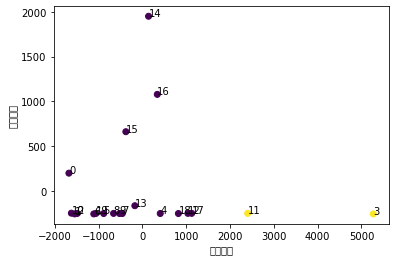

In [347]:
# 시각화
fig, ax = plt.subplots()
scatter = ax.scatter(X_pca, Y_pca, c=kmeans.labels_, cmap='viridis')
plt.xlabel('취약계층')
plt.ylabel('취약요인')


# 각 점들 위에 '각각의 동' 이름 표시
for i, txt in enumerate(df.index):
    ax.annotate(txt, (X_pca[i], Y_pca[i]))

plt.show()

/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52789 (\N{HANGUL SYLLABLE CEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
 

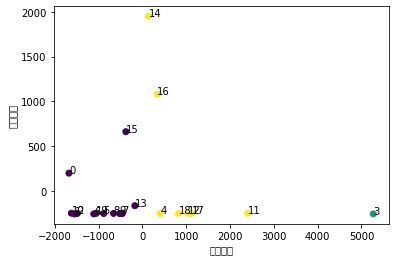

In [348]:
# cluster 3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(np.concatenate((X_pca, Y_pca), axis=1))

labels = kmeans.labels_

# 시각화
fig, ax = plt.subplots()
scatter = ax.scatter(X_pca, Y_pca, c=labels, cmap='viridis')
plt.xlabel('취약계층')
plt.ylabel('취약요인')

# 각 점들 위에 '각각의 동' 이름 표시
for i, txt in enumerate(df.index):
    ax.annotate(txt, (X_pca[i], Y_pca[i]))

plt.show()

In [349]:
# 클러스터 결과를 지도에 시각화하기
# 1대1매핑
cluster = map_dong(labels)
# 해당 클러스터 시각화
center = [37.5704021, 126.8235599]
m = folium.Map(location=center, zoom_start=13, tiles='cartodbpositron')
m = vis_map(cluster, m)
m

/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52789 (\N{HANGUL SYLLABLE CEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
 

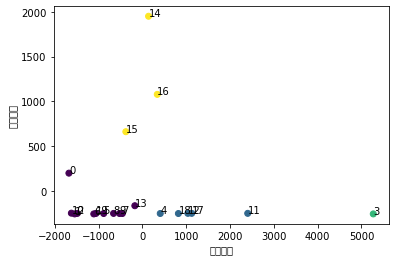

In [350]:
# cluster 4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(np.concatenate((X_pca, Y_pca), axis=1))
labels = kmeans.labels_

# 시각화
fig, ax = plt.subplots()
scatter = ax.scatter(X_pca, Y_pca, c=kmeans.labels_, cmap='viridis')
plt.xlabel('취약계층')
plt.ylabel('취약요인')

# 각 점들 위에 '각각의 동' 이름 표시
for i, txt in enumerate(df.index):
    ax.annotate(txt, (X_pca[i], Y_pca[i]))

plt.show()

In [351]:
# 1대1매핑
cluster = map_dong(labels)
# 해당 클러스터 시각화
center = [37.5704021, 126.8235599]
m = folium.Map(location=center, zoom_start=13, tiles='cartodbpositron')
m = vis_map(cluster, m)
m

/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52789 (\N{HANGUL SYLLABLE CEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
 

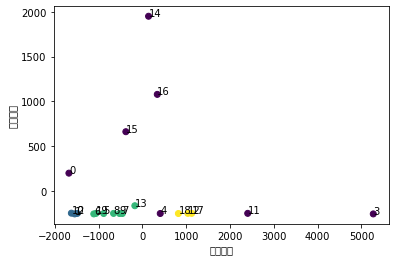

In [352]:
# DBSCAN clustering
dbscan = DBSCAN(eps=300, min_samples=2)
dbscan.fit(np.concatenate((X_pca, Y_pca), axis=1))
labels = dbscan.labels_

# 시각화
fig, ax = plt.subplots()
scatter = ax.scatter(X_pca, Y_pca, c=dbscan.labels_, cmap='viridis')
plt.xlabel('취약계층')
plt.ylabel('취약요인')

# 각 점들 위에 '각각의 동' 이름 표시
for i, txt in enumerate(df.index):
    ax.annotate(txt, (X_pca[i], Y_pca[i]))

plt.show()

In [353]:
# 1대1매핑
cluster = map_dong(labels)
# 해당 클러스터 시각화
center = [37.5704021, 126.8235599]
m = folium.Map(location=center, zoom_start=13, tiles='cartodbpositron')
m = vis_map(cluster, m)
m

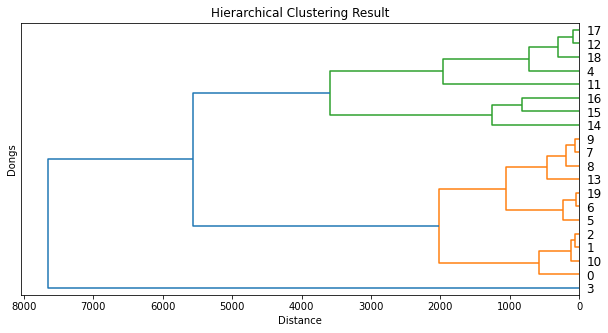

In [354]:
# Hierarchical Clustering
# concate axis=1과 같음
X_Y_pca = np.column_stack([X_pca, Y_pca])
Z = linkage(X_Y_pca, method='ward', metric='euclidean')

plt.figure(figsize=(10, 5))
dendrogram(Z, orientation='left')
plt.xlabel("Distance")
plt.ylabel("Dongs")
plt.title("Hierarchical Clustering Result")
plt.show()

# Hierarchical Clustering 시각화 추가로 필요

In [355]:
# # 여기 추가로 더 해야됨

# cluster = map_dong(labels)
# # 해당 클러스터 시각화
# center = [37.5704021, 126.8235599]
# m = folium.Map(location=center, zoom_start=13, tiles='cartodbpositron')
# m = vis_map(cluster, m)
# m

/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52789 (\N{HANGUL SYLLABLE CEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nowkim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
 

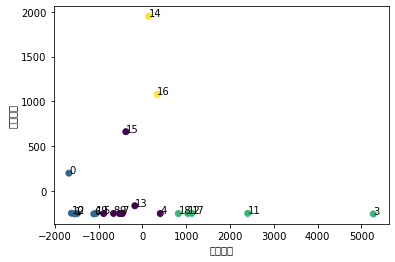

In [360]:
# SpectralClustering
# concate axis=1과 같음
X_Y_pca = np.column_stack([X_pca, Y_pca])

# spectral clustering 알고리즘 적용
spectral = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', assign_labels='kmeans')
labels = spectral.fit_predict(X_Y_pca)

# 결과 시각화
fig, ax = plt.subplots()
scatter = ax.scatter(X_pca, Y_pca, c=labels, cmap='viridis')

for i, txt in enumerate(df.index):
    ax.annotate(txt, (X_pca[i], Y_pca[i]))

plt.xlabel('취약계층')
plt.ylabel('취약요인')
plt.show()


In [361]:
# 1대1매핑
cluster = map_dong(labels)
# 해당 클러스터 시각화
center = [37.5704021, 126.8235599]
m = folium.Map(location=center, zoom_start=13, tiles='cartodbpositron')
m = vis_map(cluster, m)
m